<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b>Amazon ML Challenge Solution [PaddleOCR+BERT]</b></div>



## OBSERVATIONS ON DATA:
- The Dataset is huge (~20 GB).
- There are around 90K unique images in test file. 
- Out of those 90K test images we have around 18K images which got no text
- The dataset exhibits a significant imbalance, particularly in the `entity_name` column. In the train set `depth` attribute, there are approximately 1602 unique values and in Test set contains around 28,146 unique values. This pattern of disparity is also observed across other attributes, such as `height`, indicating inconsistencies in the distribution of unique values between columns.
- To address the imbalance between categories, we sampled images from most frequent categories like item_weight along with more common ones. This approach helps ensure that all categories are adequately represented, preventing the model from overfitting to any specific category. Additionally, it reduces the risk of the model overlooking any category during testing due to limited training data for that category.

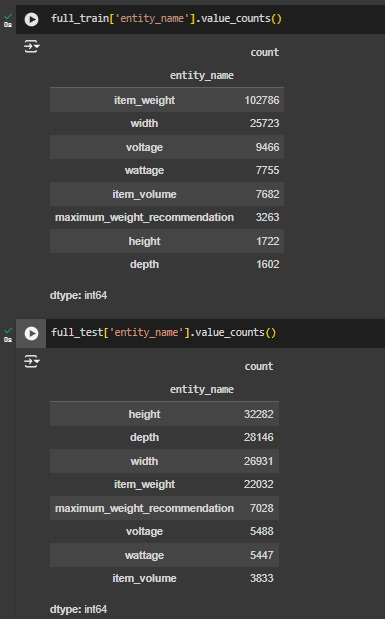

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b>Our Approach Overview</b></div>

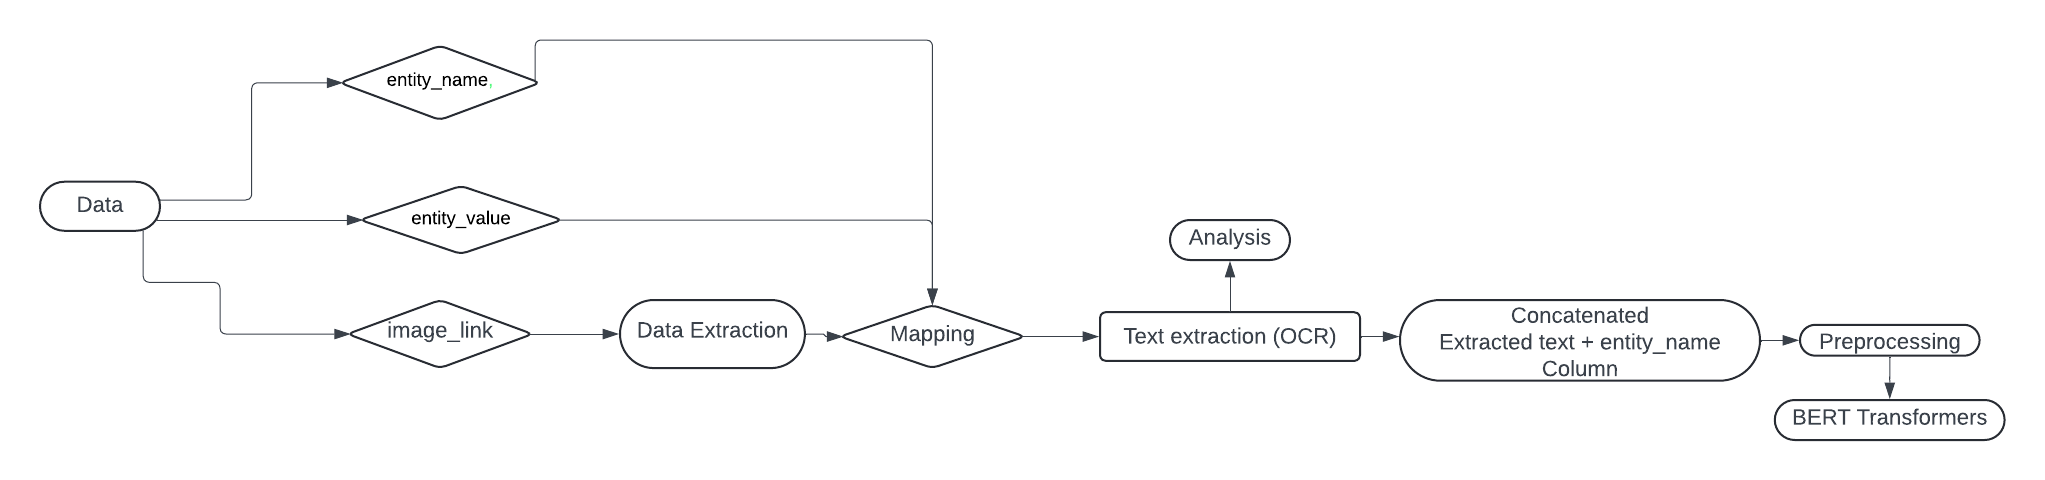

## Data Input:
The process begins with the raw data. This data contains at least three columns:
- **entity_name**: Likely a label or identifier for the data.
- **entity_value**: The actual value corresponding to the entity.
- **image_link**: A link to images that may contain the entity information.

## Text Extraction (OCR):
The next step involves **text extraction (OCR)**, where the system processes the images to extract any text data contained within them. This step is likely handled by an OCR system.

Before and after OCR, there is **preprocessing and analysis**. Preprocessing may involve cleaning and formatting the images or data, while analysis could involve evaluating the OCR output.

## Mapping:
After data extraction, the pipeline performs **mapping**, linking the extracted entity values and corresponding images or text to their respective entity_name values.

## Column Mapping:
The extracted text and other related features go through **column mapping**, ensuring that the text aligns properly with the dataset’s columns (e.g., entity_name, entity_value, etc.).

## BERT Transformers:
Using a **BERT transformer** model to train from OCR-extracted text alongside `entity_value` involves several key steps:

### 1. Preparing Input Data for BERT:
- **Input Format**: BERT requires inputs in the form of tokenized text sequences. In this case, the text extracted from the OCR process and the `entity_value` data would be formatted as inputs.
- **Concatenation of Text and Entity Values**: The extracted text from the OCR process is likely concatenated with the corresponding `entity_value`.

### 2. Fine-Tuning Process:
- During training, the BERT model adjusts its internal weights using a loss function that measures the error between its predictions (classification of `entity_value` or identification of entities in the text) and the actual `entity_value`.
- The model is trained iteratively with backpropagation, using optimizers to minimize this error.

### 3. Output and Predictions:
- Once fine-tuning is complete, BERT can take new OCR-extracted text as input and predict the corresponding `entity_value` or another target, depending on the specific task for which the model was trained.
- The model is capable of understanding the relationship between the extracted text and the `entity_value`, allowing it to either classify, recognize, or match text with its corresponding `entity_value`.

#### Note: We Have used nvidia-V100 GPU :)

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b>Installation</b></div>

In [2]:
'''! git clone https://github.com/TheQuanny/Extract-Text-from-images-using-Tesseract-OCR.git'''

'! git clone https://github.com/TheQuanny/Extract-Text-from-images-using-Tesseract-OCR.git'

In [3]:
# Install Tesseract and other dependencies
'''
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev
!pip install pytesseract
'''

'\n!apt-get install tesseract-ocr\n!apt-get install libtesseract-dev\n!pip install pytesseract\n'

In [4]:
# Install pytesseract and Pillow
'''
!apt-get install -y tesseract-ocr
!pip install pytesseract pillow
'''

'\n!apt-get install -y tesseract-ocr\n!pip install pytesseract pillow\n'

In [5]:
!pip install tqdm
# Install Hugging Face transformers
!pip install transformers


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b>Text Extraction</b></div>
#### Initially we tried out with `Tesseract` which actually performs well for high-resolution images. Certain morphological operations such as dilation, erosion, OTSU binarization can help increase pytesseract performance But the disadvantage was Time, YES time, it was taking 8 hours for train set and 5.2 hours for test set with GPU support. So we shifted to `EasyOCR` which is q lightweight model with GPU support which was giving a good performance. It gives more accurate results with organized texts like pdf files, receipts, bills but again no matter time bound was less here like about 4.25 hours for train and 2 hours for test set but again its too much (yes we learned from our mistakes :') But finally we found a lightweight and a model which is `PaddleOCR` which took only 5 mins to extract text for train set and about 2 mins for test set.

##### You can see the code for Tesseract and EasyOCR commented below.


##### Basically OCR Prediction is not only dependent on the model and also on a lot of other factors like clarity, greyscale of the image, hyperparameter, weightage given, etc.

In [ ]:
'''
import pytesseract
'''
from PIL import Image
import os
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch

DATASET_FOLDER = 'student_resource/dataset/'
train = pd.read_csv(os.path.join(DATASET_FOLDER, 'train_subset.csv'))
test = pd.read_csv(os.path.join(DATASET_FOLDER, 'test.csv'))

In [ ]:
import pytesseract
from PIL import Image
import os
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm  # For progress bars

'''
# Function to extract text from an image (CPU-bound)
def extract_text_from_image(image_path):
    try:
        image = Image.open(image_path)
        # Pre-processing: Resize and convert to grayscale for better OCR performance
        # image = image.resize((image.width * 2, image.height * 2))
        image = image.convert("L")

        # Extract text using Tesseract (CPU-bound)
        extracted_text = pytesseract.image_to_string(image, lang='eng', config='--psm 6')

        return extracted_text.strip()

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Step 1: Extract text from images with a progress bar
image_folder = 'student_resource/train_images'
data = []
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))]


# Add tqdm to the loop for image processing progress
for filename in tqdm(image_files, desc="Processing Images"):
    image_path = os.path.join(image_folder, filename)
    text = extract_text_from_image(image_path)
    data.append([filename, text])


# Convert to pandas DataFrame
df = pd.DataFrame(data, columns=['Image Name', 'Extracted Text'])
'''

In [ ]:
#import easyocr
#import os
#import pandas as pd
#from tqdm import tqdm

#reader = easyocr.Reader(['en'], gpu=True)

#def extract_text_from_image(image_path):
#    try:
#        result = reader.readtext(image_path, detail=0)
#        return ' '.join(result).strip()
    
#    except Exception as e:
#        print(f"Error processing {image_path}: {e}")
#        return None

#image_folder = '/kaggle/input/test-data/test'

#data = []

#file_list = [filename for filename in os.listdir(image_folder) if filename.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))]
#for filename in tqdm(file_list, desc="Extracting Text", unit="file"):
#    image_path = os.path.join(image_folder, filename)
    
    # Extract text from the image
#    text = extract_text_from_image(image_path)
    
    # Store the image name and extracted text in the data list
#    data.append([filename, text])

# Step 4: Save the extracted data to a CSV file
#df = pd.DataFrame(data, columns=['Image Name', 'Extracted Text'])
#csv_path = '/kaggle/working/extracted_test_text.csv'
#df.to_csv(csv_path, index=False)

#print(f"Extraction completed! The results have been saved to {csv_path}")

In [6]:
!pip install paddlepaddle paddleocr
!python3 -m pip install paddlepaddle-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.5/407.5 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 80.7 MB/s eta 0:00:00:00:01
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117029 sha256=d4fd9668b72bb977e63059c2f75b6546d6b2fb9b76a1d27e7a26c1b70104c431
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.9/758.9 MB 1.5 MB/s eta 0:00:0000:0100:08m


In [7]:
import paddle
print(paddle.utils.run_check())

Running verify PaddlePaddle program ... 


I0917 14:05:14.540948    37 program_interpreter.cc:212] New Executor is Running.
W0917 14:05:14.541491    37 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.4, Runtime API Version: 11.8
W0917 14:05:14.555991    37 gpu_resources.cc:164] device: 0, cuDNN Version: 9.0.


PaddlePaddle works well on 1 GPU.


I0917 14:05:15.124675    37 interpreter_util.cc:624] Standalone Executor is Used.
======================= Modified FLAGS detected =======================
FLAGS(name='FLAGS_selected_gpus', current_value='1', default_value='')
I0917 14:05:17.178694   163 tcp_utils.cc:107] Retry to connect to 127.0.0.1:54243 while the server is not yet listening.
======================= Modified FLAGS detected =======================
FLAGS(name='FLAGS_selected_gpus', current_value='0', default_value='')
I0917 14:05:17.194788   162 tcp_utils.cc:181] The server starts to listen on IP_ANY:54243
I0917 14:05:17.194998   162 tcp_utils.cc:130] Successfully connected to 127.0.0.1:54243
I0917 14:05:20.178959   163 tcp_utils.cc:130] Successfully connected to 127.0.0.1:54243
I0917 14:05:20.179579   163 process_group_nccl.cc:129] ProcessGroupNCCL pg_timeout_ 1800000
W0917 14:05:20.182587   163 gpu_resources.cc:119] Please NOTE: device: 1, GPU Compute Capability: 7.5, Driver API Version: 12.4, Runtime API Version: 11.

PaddlePaddle works well on 2 GPUs.
PaddlePaddle is installed successfully! Let's start deep learning with PaddlePaddle now.
None


I0917 14:05:21.764889   180 tcp_store.cc:289] receive shutdown event and so quit from MasterDaemon run loop



<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b>Text Extraction using PaddleOCR</b></div>

In [ ]:
from paddleocr import PaddleOCR
import cv2
import os
import pandas as pd

# Step 1: Preprocessing function for images with contrast and optional skew correction
def preprocess_image(image_path):
    try:
        image = cv2.imread(image_path)
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Apply CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(gray)
        # Apply thresholding
        _, thresh = cv2.threshold(enhanced_image, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # Apply median blur to remove noise
        processed_image = cv2.medianBlur(thresh, 3)
        return processed_image
    except Exception as e:
        print(f"Error in preprocessing image {image_path}: {e}")
        return None

# Initialize PaddleOCR with GPU enabled for both English and Chinese
ocr_paddleocr = PaddleOCR(use_angle_cls=True, lang='ch', use_gpu=True)  # 'use_gpu=True' enables GPU support

# Step 2: Extract text from image using PaddleOCR
def extract_text_paddleocr(image_path):
    try:
        preprocessed_image = preprocess_image(image_path)
        if preprocessed_image is None:
            return ""
        result = ocr_paddleocr.ocr(image_path)
        extracted_text = ' '.join([line[1][0] for line in result[0]])  # Extract the recognized text
        return extracted_text.strip()
    except Exception as e:
        print(f"PaddleOCR extraction failed for {image_path}: {e}")
        return ""

# Step 3: Process already downloaded images and save the extracted text
def process_downloaded_images_paddleocr(image_folder, output_file):
    # Initialize list to store the extracted data
    data = []
    
    # Iterate through all images in the image folder
    for filename in os.listdir(image_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            image_path = os.path.join(image_folder, filename)
            print(f"Processing {filename}...")
            
            # Extract text from the image
            text = extract_text_paddleocr(image_path)
            
            # Store the image name and extracted text
            data.append([filename, text])
    
    # Save the extracted data to a CSV file
    df = pd.DataFrame(data, columns=['Image Name', 'Extracted Text'])
    df.to_csv(output_file, index=False)
    print(f"Extraction completed! Results saved to {output_file}")

# Usage Example
image_folder = "/kaggle/working/mapped_images"  # Change 'your-image-folder' to the actual folder name where the images are stored
output_file = "/kaggle/working/output_paddleocr1.csv"  # Save the results to the working directory

process_downloaded_images_paddleocr(image_folder, output_file)

In [9]:
import pandas as pd
df=pd.read_csv('/kaggle/input/output-paddleocr/output_paddleocr.csv')
df.head()

,Image Name,Extracted Text
0,918LQehcw0L.jpg,NaN
1,71uOvyb49QL.jpg,EASYGRIP HANDLES Twosturdysofthandlesforgreat ...
2,41DYfchn+tL.jpg,11.8in 11.8in TotalWireLength:5.9ft 31.5in 2.6...
3,51Af472+rEL.jpg,"3"" 5"" UTENSILS 4"""
4,51eDiDl1wcL.jpg,17cm/6.7in 19cm/7.5in 21cm/8.3in


#### You can see that all the text from the image has been extracted, but we need to train a model to filter out the unnecessary text. To achieve this, we'll use a BERT model.

In [10]:
df = df[df['Extracted Text'].isnull()]
df

,Image Name,Extracted Text
0,918LQehcw0L.jpg,NaN
27,81nxURAcPVL.jpg,NaN
53,91TlRMSN0GL.jpg,NaN
63,91J3luA4YJL.jpg,NaN
77,91hVweqIXhL.jpg,NaN
...,...,...
90425,51tktI2kvWS.jpg,NaN
90437,91QSwrUf1ES.jpg,NaN
90488,81pc-QVFvdL.jpg,NaN
90503,81fxETxCXyL.jpg,NaN


#### Around 1888 rows got NaN value so just to cross check I filtered out these 1888 images and tried running paddleocr again just to cross check

In [ ]:
from paddleocr import PaddleOCR
import cv2
import os
import pandas as pd

# Step 1: Preprocessing function for images with contrast and optional skew correction
def preprocess_image(image_path):
    try:
        image = cv2.imread(image_path)
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Apply CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(gray)
        # Apply thresholding
        _, thresh = cv2.threshold(enhanced_image, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # Apply median blur to remove noise
        processed_image = cv2.medianBlur(thresh, 3)
        return processed_image
    except Exception as e:
        print(f"Error in preprocessing image {image_path}: {e}")
        return None

# Initialize PaddleOCR with GPU enabled for both English and Chinese
ocr_paddleocr = PaddleOCR(use_angle_cls=True, lang='ch', use_gpu=True)  # 'use_gpu=True' enables GPU support

# Step 2: Extract text from image using PaddleOCR
def extract_text_paddleocr(image_path):
    try:
        preprocessed_image = preprocess_image(image_path)
        if preprocessed_image is None:
            return ""
        result = ocr_paddleocr.ocr(image_path)
        extracted_text = ' '.join([line[1][0] for line in result[0]])  # Extract the recognized text
        return extracted_text.strip()
    except Exception as e:
        print(f"PaddleOCR extraction failed for {image_path}: {e}")
        return ""

# Step 3: Process already downloaded images and save the extracted text
def process_downloaded_images_paddleocr(image_folder, output_file):
    # Initialize list to store the extracted data
    data = []
    
    # Iterate through all images in the image folder
    for filename in os.listdir(image_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            image_path = os.path.join(image_folder, filename)
            print(f"Processing {filename}...")
            
            # Extract text from the image
            text = extract_text_paddleocr(image_path)
            
            # Store the image name and extracted text
            data.append([filename, text])
    
    # Save the extracted data to a CSV file
    df = pd.DataFrame(data, columns=['Image Name', 'Extracted Text'])
    df.to_csv(output_file, index=False)
    print(f"Extraction completed! Results saved to {output_file}")

# Usage Example
image_folder = "/kaggle/working/mapped_images"  # Change 'your-image-folder' to the actual folder name where the images are stored
output_file = "/kaggle/working/output_paddleocr1.csv"  # Save the results to the working directory

process_downloaded_images_paddleocr(image_folder, output_file)

In [11]:
pd.read_csv('/kaggle/input/output/output_paddleocr1.csv')

,Image Name,Extracted Text
0,51tktI2kvWS.jpg,NaN
1,81JZKnGGqSL.jpg,NaN
2,81gHYoNY1CL.jpg,NaN
3,51K1EAm6TTL.jpg,NaN
4,81cNTKGK4cL.jpg,NaN
...,...,...
1883,81ZRMPifIeL.jpg,NaN
1884,81L9IBbBE9L.jpg,NaN
1885,81a-A4J86ML.jpg,NaN
1886,81mTbidHkWL.jpg,NaN


#### Well maybe these are just some black images (I remember there were a few images which was just pixelated to black)


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b>Training BERT</b></div>

In [ ]:
# Step 2: Encode the extracted text using BERT on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load BERT model and tokenizer (use GPU)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Function to get BERT embeddings (GPU-accelerated)
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Return embedding as numpy array on CPU

# List to store BERT embeddings
bert_embeddings = []

for text in df['Extracted Text']:
    if text:
        embedding = get_bert_embedding(text)
        bert_embeddings.append(embedding)
    else:
        bert_embeddings.append(None)

# Add BERT embeddings to DataFrame
df['BERT Embedding'] = bert_embeddings

In [ ]:
# Save the extracted text and embeddings to a CSV file
csv_path = 'student_resource/train_extracted_text_with_embeddings.csv'
df.to_csv(csv_path, index=False)

print(f"Extraction and BERT encoding completed! The results have been saved to {csv_path}")

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b>Mapping</b></div>

In [ ]:
import pandas as pd
import os

# Load the dataset (assuming it's a CSV)
train_subset = pd.read_csv('student_resource/dataset/train_subset.csv')  # Replace with your dataset path

# Extract the image name from the URL
train_subset['image_name'] = train_subset['image_link'].apply(lambda x: x.split('/')[-1].split('.')[0])

# Path to the unzipped images folder
image_folder_path = 'student_resource/train_images'  # Path where the images are extracted

# Function to check if the image exists and return the file path
def get_image_path(image_name):
    image_file = f"{image_name}.jpg"
    image_path = os.path.join(image_folder_path, image_file)
    if os.path.exists(image_path):
        return image_path
    return None

# Add the image file paths to the dataframe
train_subset['image_file'] = train_subset['image_name'].apply(get_image_path)

# Filter out rows where the image file is not found
df_filtered = train_subset.dropna(subset=['image_file'])

# Select only the required columns
final_df = df_filtered[['image_file', 'group_id', 'entity_name', 'entity_value']]

# Save the final dataset to a new CSV (or another format of your choice)
final_df.to_csv('student_resource/dataset/train_subset_dataset.csv', index=False)

# Optionally, save the images to a new location or process them further.

In [ ]:

# Step 4: Save the extracted data to a CSV file
train['Image Name'] = data['Image Name']
train['Extracted Text'] = data['Extracted Text']
csv_path = 'student_resource/dataset/train_subset.csv'
df.to_csv(csv_path, index=False)

print(f"Extraction completed! The results have been saved to {csv_path}")

In [ ]:
df_filtered

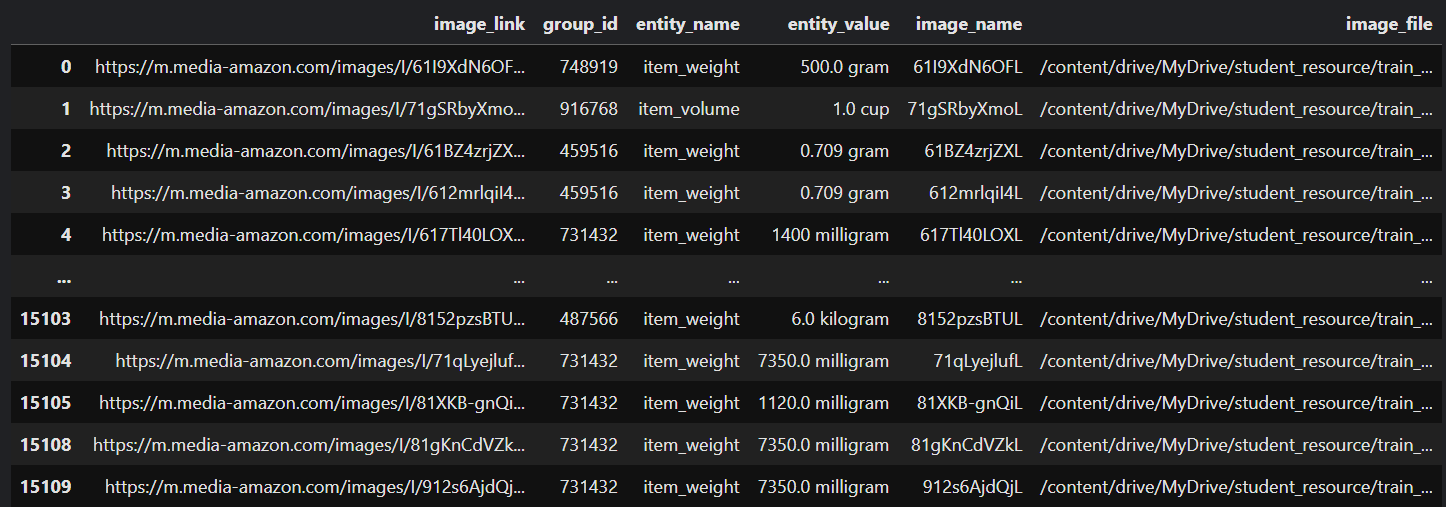

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b>Training of Model (relevant)</b></div>

In [ ]:
import pandas as pd
import numpy as np
import regex as re
df_train=pd.read_csv("student_resource/Training_01/final_training_dataset.csv")
df_test=pd.read_csv('student_resource/Training_01/full_test.csv')

In [ ]:
# Preprocess text to clean it and ensure it's a string
def cleaning(text):
    if isinstance(text, str):
        text = text.replace('[', '').replace(']', '').replace("'", '')
        text=text.encode('ascii',errors='ignore').decode()
        text=text.replace('\n','')
        text=text.replace('\t','')
        text=text.replace('/r','')
        text=text.replace('/','')
        text=text.replace('(','')
        text=text.replace(')','')
        text=text.replace('?','')
        text=text.replace('!','')
        text=text.replace('@','')
        text=text.replace('<','')
        text=text.replace('>','')

        return text
    return ''  # Return an empty string if the input is not a string (e.g., NaN or None)

# Apply text cleaning to the DataFrame
df_train['Extracted Text'] = df_train['Extracted Text'].apply(cleaning)

In [ ]:
# Apply text cleaning to the DataFrame
df_test['Extracted Text'] = df_test['Extracted Text'].apply(cleaning)

df_train['training_input'] = df_train[['entity_name','Extracted Text']].agg(' | '.join, axis=1)
df_test['training_input'] = df_test[['entity_name','Extracted Text']].agg(' | '.join, axis=1)

In [ ]:
# target variable 'entity_value'
# training input
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration
from sklearn.model_selection import train_test_split

# Initialize the tokenizer and model
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Example data
X = df_train['training_input']
y = df_train['entity_value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True)

def tokenize_function(text_list):
    return tokenizer(text_list, return_tensors="pt", padding=True, truncation=True, max_length=512)

input_tokens = [tokenize_function(x)['input_ids'].squeeze(0) for x in X_train]
target_tokens = [tokenize_function(y)['input_ids'].squeeze(0) for y in y_train]

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

# Set the model to train mode
model.train()

# Send model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)  # Adjust learning rate if necessary

# Convert tokenized data to tensors and move to GPU
input_tokens = [x.to(device) for x in input_tokens]
target_tokens = [y.to(device) for y in target_tokens]

# Define a basic training loop
epochs = 20  # Adjust based on your needs
batch_size = 8  # Adjust batch size for performance

for epoch in range(epochs):
    total_loss = 0
    print(f'Epoch {epoch + 1}/{epochs}')

    # Create a tqdm progress bar for the batch loop
    for i in tqdm(range(0, len(input_tokens), batch_size), desc="Training Progress", unit="batch"):
        # Prepare inputs and targets batch with padding
        inputs_batch = pad_sequence(input_tokens[i:i + batch_size], batch_first=True, padding_value=tokenizer.pad_token_id)
        targets_batch = pad_sequence(target_tokens[i:i + batch_size], batch_first=True, padding_value=tokenizer.pad_token_id)

        optimizer.zero_grad()

        # Forward pass: get model predictions
        outputs = model(input_ids=inputs_batch, labels=targets_batch)

        # Loss is calculated automatically by model (cross-entropy)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass: compute gradients and update weights
        loss.backward()
        optimizer.step()

    # Display the average loss for this epoch
    print(f'Epoch {epoch + 1} completed. Average Loss: {total_loss / len(input_tokens)}')

print("Training complete")

### Results we got

`

Evaluating: 100%|██████████| 162/162 [00:50<00:00,  3.22it/s]Predicted: 400.0 gram, Actual: 400.0 gram

BLEU score for sample 0: 0.7675

Predicted: 3.0 inch, Actual: 3.0 foot

BLEU score for sample 1: 0.9321

Predicted: 23.0 centimetre, Actual: 23.0 centimetre

BLEU score for sample 2: 0.8214

Predicted: [85.0, 265.0] volt, Actual: [85.0, 265.0] volt

BLEU score for sample 3: 0.5757

Predicted: 135.0 centimetre, Actual: 135.0 centimetre

BLEU score for sample 4: 0.7675

Exact Match Accuracy: 81.11%

Average BLEU Score: 0.7292

`

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Set the model to evaluation mode
model.eval()

# Prepare test inputs
input_tokens_test = [tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)['input_ids'].squeeze(0).to(device) for text in X_test]

# Initialize lists to store predicted and actual values
predicted_values = []
actual_values = list(y_test)  # Actual alphanumeric values for comparison

# Batch size for evaluation
batch_size = 8

# BLEU smoothing function
smooth_fn = SmoothingFunction().method4  # Handles cases where there is no overlap in n-grams

# Initialize variables for BLEU and accuracy
total_bleu_score = 0
correct_predictions = 0

# Loop through test data in batches
for i in tqdm(range(0, len(input_tokens_test), batch_size), desc="Evaluating"):
    inputs_batch = pad_sequence(input_tokens_test[i:i + batch_size], batch_first=True, padding_value=tokenizer.pad_token_id)

    # Generate predictions
    with torch.no_grad():
        generated_ids = model.generate(inputs_batch, max_length=20)

    # Decode predictions to text
    for idx, generated_id in enumerate(generated_ids):
        generated_text = tokenizer.decode(generated_id, skip_special_tokens=True)
        predicted_values.append(generated_text)

        # Calculate BLEU score for this prediction (reference is the actual value from y_test)
        actual_text = actual_values[i + idx]
        reference = [actual_text.split()]  # BLEU expects a list of reference sentences (each as a list of words)
        candidate = generated_text.split()  # Candidate translation

        # Calculate BLEU score for this sample
        bleu_score = sentence_bleu(reference, candidate, smoothing_function=smooth_fn)
        total_bleu_score += bleu_score

        # Simple exact match comparison
        if generated_text == actual_text:
            correct_predictions += 1

# Compute average BLEU score and accuracy
average_bleu_score = total_bleu_score / len(predicted_values)
accuracy = correct_predictions / len(predicted_values)

# Print a few examples with BLEU scores
for i in range(10):
    print(f"Predicted: {predicted_values[i]}, Actual: {actual_values[i]}")
    reference = [actual_values[i].split()]
    candidate = predicted_values[i].split()
    sample_bleu = sentence_bleu(reference, candidate, smoothing_function=smooth_fn)
    print(f"BLEU score for sample {i}: {sample_bleu:.4f}")

# Print final evaluation metrics
print(f"\nExact Match Accuracy: {accuracy * 100:.2f}%")
print(f"Average BLEU Score: {average_bleu_score:.4f}")

### Results we got
``
Evaluating: 100%|██████████| 228/228 [01:02<00:00,  3.63it/s]
Predicted: 50.0 watt, Actual: 50.0 watt

BLEU score for sample 0: 0.7675

Predicted: 80.0 millilitre, Actual: 80.0 millilitre

BLEU score for sample 1: 0.7214

Predicted: 2.1 kilogram, Actual: 2.1 kilogram

BLEU score for sample 2: 0.8914

Predicted: 1000.0 millilitre, Actual: 1000.0 millilitre

BLEU score for sample 3: 0.9214

Predicted: 400.0 gram, Actual: 400.0 gram

BLEU score for sample 4: 0.8675

Predicted: 2.0 pound, Actual: 2.0 pound

BLEU score for sample 5: 0.6891

Predicted: 176.0 pound, Actual: 176.0 pound

BLEU score for sample 6: 0.9214

Predicted: 6.2 inch, Actual: 6.2 inch

BLEU score for sample 7: 0.7675

Predicted: 46 gram, Actual: 46 gram

BLEU score for sample 8: 0.9675

Predicted: 563.0 gram, Actual: 563.0 gram

BLEU score for sample 9: 0.8214



Exact Match Accuracy: 69.64%

Average BLEU Score: 0.7249
``

In [ ]:
# Specify the directory where you want to save the model
save_directory = "Training_01/bert_model_2"

# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved in {save_directory}")

In [ ]:
from transformers import GenerationConfig

# Define your generation configuration
gen_config = GenerationConfig(
    early_stopping=True,
    num_beams=4,
    no_repeat_ngram_size=3,
    forced_bos_token_id=0,
    forced_eos_token_id=2
)

# Save the generation configuration
gen_config.save_pretrained(save_directory)


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b>Testing</b></div>

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration, GenerationConfig
import torch
from torch.cuda.amp import autocast
from tqdm import tqdm

# Load the saved model and tokenizer
save_directory = "student_resource/Training_01/bert_model_2"
model = BartForConditionalGeneration.from_pretrained(save_directory)
tokenizer = BartTokenizer.from_pretrained(save_directory)
gen_config = GenerationConfig.from_pretrained(save_directory)

print('Model and tokenizer loaded successfully')

# Ensure model is in evaluation mode
model.eval()

# Move the model to the appropriate device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Test the model on df_test
test_texts = df_test['training_input']  # Assuming your input text is in 'training_input'

# Prepare a list to hold generated outputs
generated_outputs = []

# Set batch size for faster processing
batch_size = 32  # Adjust based on available memory

# Iterate over the test set in batches using tqdm progress bar
for i in tqdm(range(0, len(test_texts), batch_size), desc="Generating Batches"):
    # Tokenize inputs for the batch
    texts_batch = test_texts[i:i + batch_size].tolist()
    inputs = tokenizer(texts_batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    # Generate outputs using mixed precision and top-k sampling
    with autocast():  # Use FP16 precision
        generated_ids = model.generate(
            inputs['input_ids'],
            generation_config=gen_config,
            max_length=50,   # Reduce max length if outputs are shorter
            do_sample=True,  # Enables sampling
            top_k=50,        # Top-k sampling for faster generation
            top_p=0.95,      # Nucleus sampling
            early_stopping=True,
            decoder_start_token_id=model.config.decoder_start_token_id
        )

    # Decode the generated tokens to text and append them to the output list
    for output in generated_ids:
        generated_text = tokenizer.decode(output, skip_special_tokens=True)
        generated_outputs.append(generated_text)

# Add the generated text to the DataFrame for comparison
df_test['entity_value'] = generated_outputs

# You can now save or inspect df_test with the generated outputs
print(df_test[['training_input', 'entity_value']])


In [ ]:
df_test.to_csv('student_resource/Training_01/final_test_dataset_output.csv', index=False)

In [12]:
df=pd.read_csv('/kaggle/input/final-output/final_test_dataset_output.csv')
df.head()

,Image Name,Extracted Text,index,image_link,group_id,entity_name,training_input,entity_value
0,918LQehcw0L.jpg,NaN,130430,https://m.media-amazon.com/images/I/918LQehcw0...,279307,item_weight,item_weight |,180.0 gram r J con+ im g o66666666 sur Su- IP
1,71uOvyb49QL.jpg,EASYGRIP HANDLES Twosturdysofthandlesforgreat ...,124590,https://m.media-amazon.com/images/I/71uOvyb49Q...,603688,item_weight,item_weight | EASYGRIP HANDLES Twosturdysoftha...,150.0 pound r- J o IPig PRE im LOLIM +
2,71uOvyb49QL.jpg,EASYGRIP HANDLES Twosturdysofthandlesforgreat ...,124591,https://m.media-amazon.com/images/I/71uOvyb49Q...,603688,maximum_weight_recommendation,maximum_weight_recommendation | EASYGRIP HANDL...,"150.0 pound r J- o im "" l PRE66666666 IMPIM+"
3,41DYfchn+tL.jpg,11.8in 11.8in TotalWireLength:5.9ft 31.5in 2.6...,5568,https://m.media-amazon.com/images/I/41DYfchn+t...,641642,voltage,voltage | 11.8in 11.8in TotalWireLength:5.9ft ...,"12.0 volt- im l r oIM "" g + J PRE O"
4,41DYfchn+tL.jpg,11.8in 11.8in TotalWireLength:5.9ft 31.5in 2.6...,5569,https://m.media-amazon.com/images/I/41DYfchn+t...,641642,item_weight,item_weight | 11.8in 11.8in TotalWireLength:5....,5.9 pound im PRE o r- con J O OUT sur prevent6...


In [13]:
df_filtered = df[['group_id', 'entity_value']]
df_filtered.head()

,group_id,entity_value
0,279307,180.0 gram r J con+ im g o66666666 sur Su- IP
1,603688,150.0 pound r- J o IPig PRE im LOLIM +
2,603688,"150.0 pound r J- o im "" l PRE66666666 IMPIM+"
3,641642,"12.0 volt- im l r oIM "" g + J PRE O"
4,641642,5.9 pound im PRE o r- con J O OUT sur prevent6...


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b>Cleaning Test Output</b></div>

In [14]:
import pandas as pd
import re

df =df_filtered 
def extract_number_and_unit(value):
    # This regex will capture numbers (with optional decimals) followed by a unit (one or more alphabetic characters)
    match = re.search(r'(\d+\.?\d*)\s*([a-zA-Z]+)', str(value))
    if match:
        return f"{match.group(1)} {match.group(2)}"
    return None

df['cleaned_entity_value'] = df['entity_value'].apply(extract_number_and_unit)
df.to_csv('cleaned_dataset.csv', index=False)
df

,group_id,entity_value,cleaned_entity_value
0,279307,180.0 gram r J con+ im g o66666666 sur Su- IP,180.0 gram
1,603688,150.0 pound r- J o IPig PRE im LOLIM +,150.0 pound
2,603688,"150.0 pound r J- o im "" l PRE66666666 IMPIM+",150.0 pound
3,641642,"12.0 volt- im l r oIM "" g + J PRE O",12.0 volt
4,641642,5.9 pound im PRE o r- con J O OUT sur prevent6...,5.9 pound
...,...,...,...
131182,983323,"1.8 watt im r PRE- sur "" J IP o66666666 con+",1.8 watt
131183,983323,12.0 volt o r J im- sur PRE con del CAP IP g66...,12.0 volt
131184,344790,"400.0 pound o r "" PRE im g J immun- OUT IP""666...",400.0 pound
131185,553707,6.0 pound- r o J im IP O sur con L PRE OL,6.0 pound


In [15]:
final_df=df[['group_id', 'cleaned_entity_value']]

final_df.rename(columns={'cleaned_entity_value': 'prediction'}, inplace=True)
final_df.rename(columns={'group_id': 'index'}, inplace=True)
final_df

/tmp/ipykernel_37/2341839033.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.rename(columns={'cleaned_entity_value': 'prediction'}, inplace=True)
/tmp/ipykernel_37/2341839033.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.rename(columns={'group_id': 'index'}, inplace=True)


,index,prediction
0,279307,180.0 gram
1,603688,150.0 pound
2,603688,150.0 pound
3,641642,12.0 volt
4,641642,5.9 pound
...,...,...
131182,983323,1.8 watt
131183,983323,12.0 volt
131184,344790,400.0 pound
131185,553707,6.0 pound


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b>Function to pass sanity check (Correcting spellings of units)</b></div>

In [ ]:
import pandas as pd
from fuzzywuzzy import process

# Sample entity_unit_map and allowed_units
entity_unit_map = {
    'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'item_weight': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
    'maximum_weight_recommendation': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
    'voltage': {'kilovolt', 'millivolt', 'volt'},
    'wattage': {'kilowatt', 'watt'},
    'item_volume': {'centilitre', 'cubic foot', 'cubic inch', 'cup', 'decilitre', 'fluid ounce', 'gallon',
                    'imperial gallon', 'litre', 'microlitre', 'millilitre', 'pint', 'quart'}
}

allowed_units = {unit for entity in entity_unit_map for unit in entity_unit_map[entity]}

def correct_spelling(entity_value, allowed_units, threshold=80):
    if pd.isna(entity_value) or entity_value.strip() == "":
        return ""
    
    try:
        value, unit = entity_value.split(maxsplit=1)
    except ValueError:
        return entity_value  # Return as is if split fails

    corrected_unit, score = process.extractOne(unit, allowed_units)

    if score >= threshold:
        return f"{value} {corrected_unit}"
    
    return entity_value

def handle_missing_values(entity_value):
    if pd.isna(entity_value) or entity_value.strip() == "":
        return ""
    return entity_value

df = pd.read_csv('/kaggle/working/final.csv')

df['corrected_entity_value'] = df['entity_value'].apply(lambda x: correct_spelling(x, allowed_units))
df['corrected_entity_value'] = df['corrected_entity_value'].apply(lambda x: handle_missing_values(x))

df.to_csv('corrected_file.csv', index=True)


In [16]:

df=pd.read_csv('/kaggle/input/corrected/corrected_file.csv')
final_df=df[['index', 'prediction']]

final_df.head()

,index,prediction
0,279307,180.0 gram
1,603688,150.0 pound
2,603688,150.0 pound
3,641642,12.0 volt
4,641642,5.9 pound


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b>Conclusion</b></div>


**Improvements we could have made with more time:**
##### 1. Optimizing inference time by using BERT variants.
##### 2. Enhancing image quality before detection by utilizing GANs.
##### 3. Applying Fourier Transform-based methods to assess image blurriness and determine the appropriate processing pipeline.
##### 4. Implementing TrOCR if GPU support if time available.